In [9]:
lts = sc.textFile('data/transm150720.csv')
lts.first()

u'79062005698500,TKTT,30,150719,FR,0.0,EUR,T,T,141025,PARA127A8,0.0,EUR,   ,EX,,150719,0.0'

In [7]:
def getTCNFechaCompra(l):
    elems = l.split(",")
    tcn = elems[0]
    fechaCompra = elems[9]
    return (tcn, fechaCompra)
getTCNFechaCompra(lts.first())

(u'79062005698500', u'141025')

In [6]:
ts = lts.map(getTCNFechaCompra)
ts.take(3)

[(u'79062005698500', u'141025'),
 (u'79062005924069', u'150719'),
 (u'79065668570385', u'150626')]

In [11]:
lcs = sc.textFile('data/coupon150720.csv')
lcs.first()

u'79062005698500,1,MAA,AUH,9W,9W,56.79,USD,1,H,H,0526,150904,OK,IAF0'

In [14]:
def getTCNFechaSalida(l):
    elems = l.split(",")
    tcn = elems[0]
    fechaSalida = elems[12]
    return (tcn, fechaSalida)
getTCNFechaSalida(lcs.first())

(u'79062005698500', u'150904')

In [17]:
cs = lcs.map(getTCNFechaSalida)
cs.take(3)

[(u'79062005698500', u'150904'),
 (u'79062005698500', u'150905'),
 (u'79062005924069', u'150721')]

In [23]:
# Selecciono la fecha más baja de los cupones
cpgs = cs.groupByKey().mapValues(lambda vs: min(vs)).cache()  # la fecha está AAMMDD, si no como la semana pasada
cpgs.take(3)

[(u'79062005558463', u'150801'),
 (u'79065668432713', u'150823'),
 (u'79062005501193', u'150720')]

In [31]:
j = cpgs.leftOuterJoin(ts).cache()
# quito las fechas vacias (fallaba la semana pasada)
fj = j.filter(lambda x: x[1][0] != '' and x[1][1] != '')
fj.take(3)

[(u'79062005994272', (u'150720', u'150719')),
 (u'79065668614400', (u'150724', u'150719')),
 (u'79062005501193', (u'150720', u'150719'))]

In [32]:
from time import strptime
from time import mktime

In [33]:
def difFechas(f1,f2):
    of1 = strptime(f1,'%y%m%d'); seg1 = mktime(of1)
    of2 = strptime(f2,'%y%m%d'); seg2 = mktime(of2)
    dif = seg1 - seg2
    return dif/3600/24

In [35]:
d = fj.mapValues(lambda v: difFechas(v[0],v[1]))
d.take(3)

[(u'79062005994272', 1.0), (u'79065668614400', 5.0), (u'79062005501193', 1.0)]

In [36]:
d.groupBy(lambda x: x[1]).take(3) # No vake aqui el group porque ya no son 16 ciupoenes por ticket como antes
                                  # El tamaño de cada grupo puede ser muuuuuuuuuuuuy grande
                                  # Hay que usar reduceByKey

[(0.0, <pyspark.resultiterable.ResultIterable at 0x7f6f4c281310>),
 (750.0, <pyspark.resultiterable.ResultIterable at 0x7f6f47152950>),
 (198.04166666666666,
  <pyspark.resultiterable.ResultIterable at 0x7f6f471529d0>)]

In [38]:
d.map(lambda x: (x[1],1)).take(3)

[(1.0, 1), (5.0, 1), (1.0, 1)]

In [40]:
r = d.map(lambda x: (int(x[1]),1)).reduceByKey(lambda e,acum: e+acum) # La suma es monoide (asociativa) y conmutativo
r.take(3)

[(0, 28366), (515, 1), (5, 16793)]

In [43]:
res = r.collect()

In [45]:
print(len(res))
print(type(res))
print(res[0:10])

452
<type 'list'>
[(0, 28366), (515, 1), (5, 16793), (10, 9906), (15, 7791), (20, 7030), (25, 6742), (540, 4), (30, 4361), (35, 3954)]


In [47]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [49]:
xs = [t[0] for t in res]
ys = [t[1] for t in res]

(0, 90)

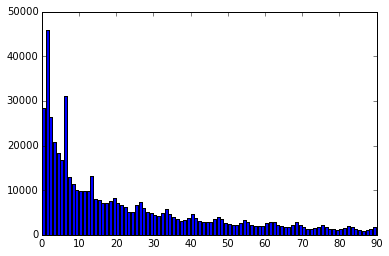

In [57]:
plt.bar(xs,ys)
plt.xlim(0,90)

In [ ]:
### Ejercicio tabla con dias de antelación y precios medios (el precio es la suma del precio de todos los cupones)